In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [4]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [6]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [7]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')
##ModeloV1T1

In [8]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

# Veo si puedo sacar los nombres directo del modelo q cargue


In [9]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [10]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [11]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [12]:
testeo[var_input]

,01_branch_working_days,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,0.182123,13.0,5145.0,0,2,1,2,0,6.0,0,False,True,0.570136,False,False,False,True,False,0,0.178218,0.660714,0.182123,0.075812,0.538542,0.002740,0.004762,0.458333
1,0.041254,2.0,271.0,0,3,3,3,0,9.0,0,False,True,0.731785,False,False,False,True,False,0,0.019802,0.267857,0.041254,0.027798,0.000000,0.019178,0.033333,0.500000
2,0.988764,25.0,6955.0,0,2,1,1,0,14.0,0,False,False,0.549978,False,False,False,True,False,0,0.019802,0.085714,0.988764,0.032491,0.000000,0.013699,0.023810,0.708333
3,0.959584,12.0,3434.0,0,3,1,3,0,1.0,0,True,True,1.000000,False,False,False,True,False,1,0.079208,0.678571,0.959584,0.216606,0.000000,0.821918,0.000000,0.458333
4,0.350159,64.0,633.0,0,1,1,0,0,16.0,0,True,True,1.127106,False,False,False,False,True,0,0.138614,0.848214,0.350159,0.083032,0.000000,0.021918,0.038095,0.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16724863,0.415563,4.0,1660.0,0,4,2,2,0,24.0,0,False,True,0.303158,False,False,False,True,False,0,0.386139,0.426786,0.415563,0.010830,0.556250,0.002740,0.004762,0.833333
16724864,0.382526,24.0,2785.0,0,5,1,4,0,3.0,0,False,True,1.153846,False,False,False,True,False,0,0.158416,0.955357,0.382526,0.036101,0.000000,0.153425,0.266667,0.666667
16724865,0.504444,3.0,18248.0,0,19,7,10,0,15.0,0,True,True,0.850608,False,False,False,False,True,0,0.306931,0.569643,0.504444,0.085921,0.000000,0.019178,0.033333,0.750000
16724866,0.037733,12.0,3572.0,0,3,1,3,0,21.0,0,False,True,0.990566,False,False,False,True,False,0,0.207921,0.600000,0.037733,0.090253,0.000000,0.063014,0.109524,0.625000


In [13]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')


In [14]:
#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()

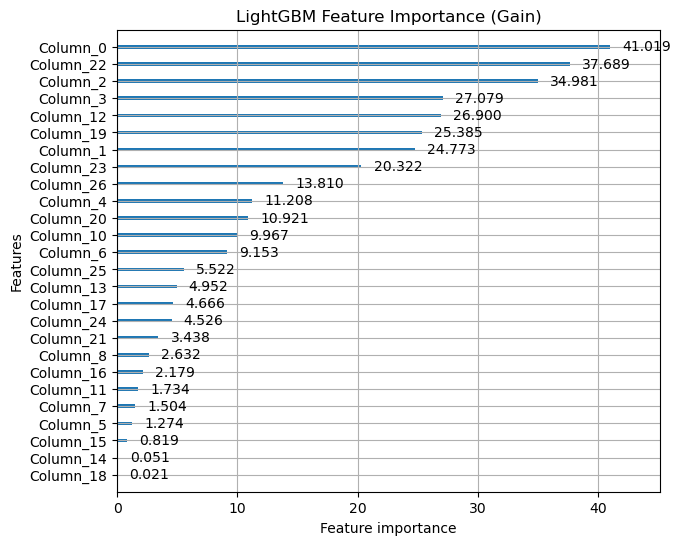

In [15]:
import lightgbm as lgb
lgb.plot_importance(modelo, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

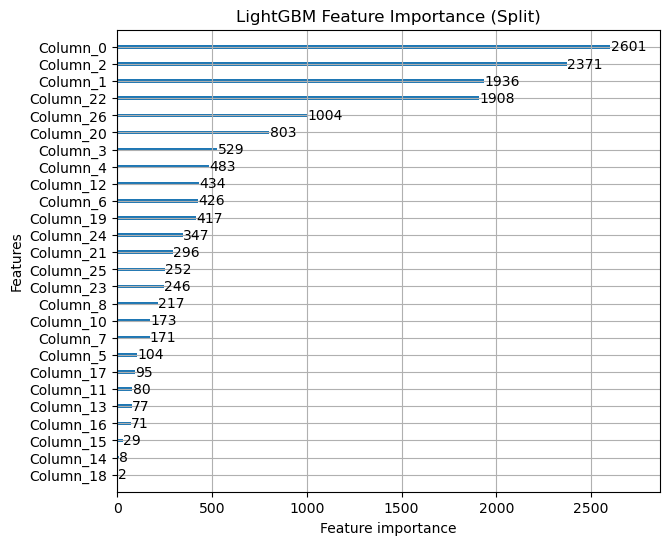

In [16]:
# Plot feature importance using Split
lgb.plot_importance(modelo, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [17]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
np.savetxt('./ModeloFinalImp2.txt', modelo.booster_.feature_importance(importance_type='split'),fmt='%f')
np.savetxt('./ModeloFinalImpG2.txt', modelo.booster_.feature_importance(importance_type='gain'),fmt='%f')

In [18]:
#Pongo el archivo q quiero testear
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [19]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [20]:
testeo['target'].value_counts(dropna=False)

target
False    6249450
True          42
Name: count, dtype: int64

In [21]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [22]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [23]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,6249433,17
1,36,6


In [24]:
corte

3.128149266709267e-07

In [63]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,6223697,25753
1,14,28


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

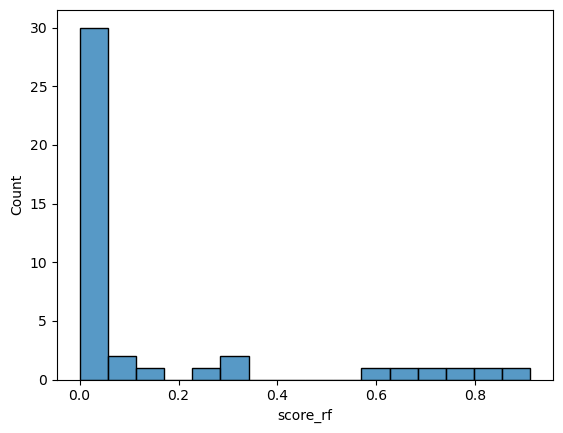

In [26]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [27]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA .04%:
0.5714285714285714


In [28]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,6229,21
2,6246,3
3,6250,0
4,6245,4
5,6249,1
...,...,...
996,6250,0
997,6249,0
998,6250,0


In [29]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             4.829789e-06  9.976629e-01
2             1.295266e-06  4.829309e-06
3             5.910975e-07  1.295173e-06
4             3.328206e-07  5.910796e-07
5             2.140723e-07  3.328076e-07
...                    ...           ...
996           2.943575e-13  3.346674e-13
997           2.517516e-13  2.943573e-13
998           2.033039e-13  2.517142e-13
999           1.431490e-13  2.033015e-13
1000          6.964442e-15  1.431356e-13

[1000 rows x 2 columns]

In [61]:
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]
pd.crosstab(tes_corte['date_receiver'].dt.month, Y_c_corte['target'])
pd.crosstab(testeo['date_receiver'].dt.month, Y_c['target'])

target,False,True
date_receiver,,
1,2132494,42
2,2016029,0
3,2100927,0


In [30]:
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,805,827,831,814,1081,1042,850
2,772,800,780,777,1098,1156,866
3,797,862,728,718,1139,1168,838
4,772,783,731,745,1177,1182,859
5,761,745,674,737,1230,1230,873
6,761,753,709,742,1129,1226,929
7,799,735,678,722,1144,1269,903
8,771,754,660,727,1247,1208,882
9,769,759,669,686,1219,1204,944


In [31]:
#DECILES.to_csv ('./deciles.csv')

In [32]:
#Guardo los puntos de corte para recodificar el score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets.to_csv ('./Buckets.csv')

In [33]:
round(Buckets['final_score'],3)

0     0.99899999999999999911
1     0.99799999999999999822
2     0.99699999999999999734
3     0.99599999999999999645
4     0.99499999999999999556
               ...          
995   0.00400000000000000008
996   0.00300000000000000006
997   0.00200000000000000004
998   0.00100000000000000002
999   0.00000000000000000000
Name: final_score, Length: 1000, dtype: Float64

## Curva ROC y FP

In [34]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [35]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [36]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [37]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
8.333322665813265
ROC FRAUD TESTEO:
0.5714272113088809


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.7726012003342009
Precision FRAUD TESTEO:
0.2608695652173913
Recall FRAUD TESTEO:
0.14285714285714285


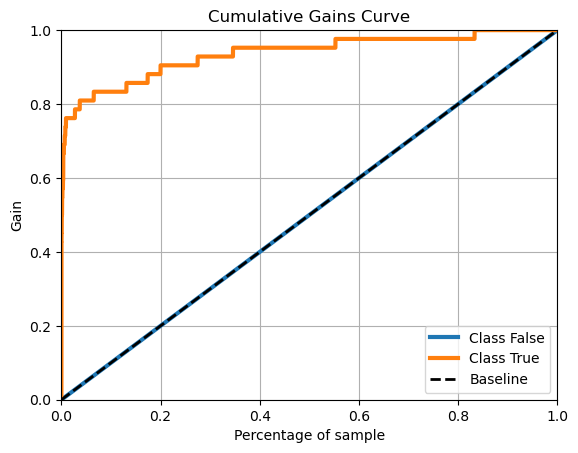

In [38]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


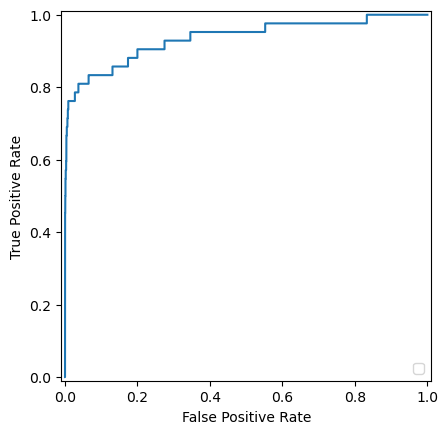

In [39]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

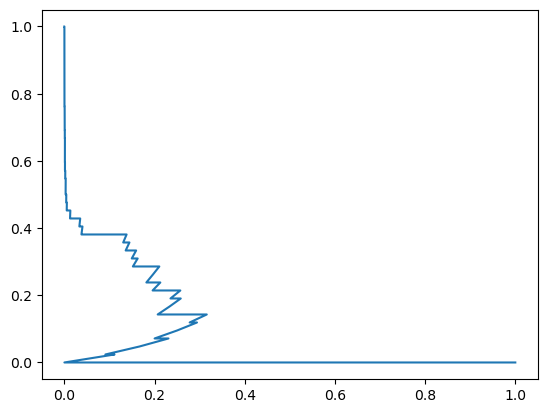

In [40]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(precision, recall)

## One given week

In [41]:
tes[tes['target']==True].head()

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,receiver_transaction_count,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,mes,hour_receiver,01_isMexico,01_sender_branch_state,01_var_range_hist,01_receiver_fraud,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_G,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,target
69550,A25883,92,2024-01-21 16:02:48.883,WI0260,NN,11293176,"1,250.00000000000000000000",1.00000000000000000000,MEX,MEX21,WI,38.00000000000000000000,NaN,NaN,USA,Real,NaN,13.00000000000000000000,0,184,WA,4,0,3,1,1,4,1,"1,250.00000000000000000000",0,1,16,True,False,1.00000000000000000000,False,True,True,False,False,True,NaN,0,NaN,0,NaN,NaN,0.00000000000000000000,NaN,0.02247191011235954994,0.45126353790613715766,NaN,NaN,NaN,NaN,0.66666666666666662966,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True
124507,A18633,10961,2024-01-09 15:03:21.343,CA3462,NN,10207302,"2,900.00000000000000000000",2.00000000000000000000,MEX,MEX11,CA,"1,530.00000000000000000000",215.00000000000000000000,0.00000000000000000000,USA,Distraction,13.00000000000000000000,11.00000000000000000000,0,2066,CA,0,0,5,1,1,0,10,372.10000000000002273737,0,1,15,True,True,7.79360386992743858769,False,False,False,False,False,True,0.00000000000000000000,0,0.00000000000000000000,0,13.00000000000000000000,13.00000000000000000000,0.00990099009900990111,0.38392857142857145236,0.27268153613952705872,1.00000000000000000000,0.00451388888888888846,0.00902777777777777693,0.00000000000000000000,0.00000000000000000000,0.62500000000000000000,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True
218303,A21721,16341,2024-01-14 16:29:44.087,FL2102,NN,9471140,"1,700.00000000000000000000",1.00000000000000000000,MEX,MEX21,FL,829.00000000000000000000,386.00000000000000000000,2.00000000000000000000,USA,Real,"2,973.00000000000000000000",7.00000000000000000000,0,4978,FL,4,0,2,2,0,4,2,"1,450.00000000000000000000",0,1,16,True,True,1.17241379310344817632,False,True,True,False,False,True,2.00000000000000000000,0,2.00000000000000000000,0,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.68928571428571427937,0.15512326010397450848,0.61371841155234652110,0.00000000000000000000,0.00000000000000000000,0.00547945205479452059,0.00952380952380952467,0.66666666666666662966,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,True
225137,A22792,11769,2024-01-19 18:03:29.477,NV0185,NN,11127765,0.00000000000000000000,1.00000000000000000000,MEX,MEX45,NV,583.00000000000000000000,NaN,NaN,USA,Distraction,NaN,4.00000000000000000000,0,5310,NV,10,0,4,3,0,10,1,0.000

In [49]:
week_testigo = tes['date_receiver'].between('2024-01-01','2024-01-30')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(2025816, (2025816, 77), (2025816, 12))

In [50]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

target,False,True
date_receiver,,
1,16048,0
2,66648,4
3,54994,0
4,55306,0
5,84566,1
6,91896,0
7,77686,5
8,66578,0
9,50878,3


In [51]:
#Veo cuantos falsos positivos tengo con el punto de corte
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False,True
date_receiver,,
1,164,0
2,517,1
3,442,0
4,455,0
5,607,0
6,567,0
7,470,5
8,531,0
9,440,0


In [52]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [53]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,...,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000
date_receiver,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,42,38,49,32,34,25,28,33,27,24,24,26,27,27,41,29,20,22,32,21,25,20,23,29,24,23,27,22,21,21,21,21,26,27,12,23,16,30,23,27,32,23,18,20,23,18,18,23,19,13,17,24,13,27,23,16,27,34,20,14,24,13,13,25,23,25,21,24,22,17,20,20,20,21,20,18,23,17,16,25,13,24,20,21,27,18,16,19,22,14,15,20,17,13,20,20,14,19,22,18,21,14,17,19,15,27,20,19,15,12,23,19,23,15,17,16,13,16,21,15,16,17,18,17,16,17,18,19,22,17,15,13,18,15,11,22,20,15,26,19,23,25,17,19,16,19,21,18,15,23,21,17,15,22,14,12,10,16,15,12,19,16,9,17,23,25,8,11,18,20,15,25,11,20,18,13,17,13,16,16,11,28,16,13,21,26,20,22,10,21,21,14,20,17,22,19,13,22,14,24,14,14,18,26,21,16,16,16,12,16,13,15,19,19,16,16,22,10,20,16,12,17,16,17,11,18,25,15,12,11,17,15,19,16,21,22,17,11,21,22,21,8,17,11,14,24,17,18,19,18,...,15,12,18,13,13,12,11,14,17,16,16,17,18,12,12,16,13,16,12,21,10,15,10,14,14,15,15,12,11,8,18,14,16,14,14,24,20,12,15,14,16,17,20,16,10,13,12,12,17,7,19,11,13,18,11,11,7,18,8,23,12,16,9,20,16,11,18,16,12,18,21,9,10,11,12,12,16,12,11,10,17,11,15,15,16,20,11,15,10,11,15,12,19,12,15,15,17,14,11,18,17,20,10,11,19,9,9,22,12,13,22,11,10,16,17,17,16,7,10,10,17,7,16,14,12,11,18,14,9,13,16,18,12,13,14,11,13,13,16,10,17,28,11,17,14,13,15,13,12,17,12,13,10,15,7,14,13,13,12,17,11,10,10,14,17,14,15,14,12,12,12,14,13,14,12,10,22,18,20,14,14,10,16,9,8,16,9,13,12,15,14,16,8,12,17,14,14,17,20,9,17,14,11,13,13,8,15,16,14,13,14,14,6,12,17,11,16,14,15,15,8,13,16,17,7,11,12,9,15,13,6,19,13,7,18,17,19,16,16,17,15,9,26,19,23,18,17,12,19,24
2,143,125,119,118,116,101,115,115,116,96,107,92,103,88,88,108,88,97,71,110,97,77,67,98,91,87,82,1

In [54]:

pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

FRAUD_DECILE,1,2,4,5,7,8,10,28,37,66,131,174,200,275,346,553,833
date_receiver,,,,,,,,,,,,,,,,,
2,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
14,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0
18,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
19,2,2,3,0,0,0,1,1,0,0,0,0,0,0,0,0,0
21,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]

,date_receiver,fraud_classification,FRAUD_DECILE
69550,21,Real,1
124507,9,Distraction,174
218303,14,Real,37
225137,19,Distraction,4
317155,24,Distraction,1
319998,19,Distraction,4
320356,19,Real,1
350389,19,Real,1
406235,18,Distraction,8
449004,14,Real,131
